# CASO DE ESTUDIO 3 - PREDICCION DEL PRECIO DEL ORO
Predicción del precio del oro con redes LSTM

## 1. Business case discovery

### 1.2 Contexto

Optimizar inveriones en metales preciosos. El oro es afectado por **inflacion, tasas de interes, crisis geopoliticas, etc**. 

Se busca analisis de datos historicos del precio del oro *(XAU/USD)* y variables macroeconomicas para predecir su valor.

### 1.3 Objetivo del proyecto

Construir una LSTM que prediga el precio del oro para los proximos **5 dias habiles**. Se usaran:
- Datos historicos diarios (2010-2024)
- Indicadores macro: Indice dolar (DXY), tasas de interes FED, inflacion, etc
- Metrica de exito: **RMSE < 2.5%**

# 2. Preprocesamiento de datos

## 2.0.5 Importacion de librerias necesarias

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# from tensorflow.keras.callbacks import EarlyStopping
# from sklearn.model_selection import KFold

2025-04-25 10:06:40.268368: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745568401.815822    1545 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745568402.268958    1545 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745568405.838510    1545 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745568405.838537    1545 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745568405.838539    1545 computation_placer.cc:177] computation placer alr

In [2]:
!pip install yfinance

## 2.1 Origen de datos
- Precio: Yahoo Finance (`GC-F`)
- Datos macro: Yahoo Finance

In [3]:
import yfinance as yf

# 1. Precio del oro (futuros)
df_oro = yf.download("GC=F", start="2010-01-01")

# 2. Índice Dólar (DXY)
df_dxy = yf.download("DX-Y.NYB", start="2010-01-01")  # Ticker correcto para DXY

# 3. Bonos 10 años (^TNX como proxy de tasas de interés)
df_bonos = yf.download("^TNX", start="2010-01-01")

# 4. Inflación (usar ETF TIP como proxy)
df_inflacion = yf.download("TIP", start="2010-01-01")  # ETF de bonos indexados a inflación

df_oro.head()
# df_dxy.head()
# df_bonos.head()
# df_inflacion.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,GC=F,GC=F,GC=F,GC=F,GC=F
Date,,,,,
2010-01-04,1117.699951,1122.300049,1097.099976,1117.699951,184
2010-01-05,1118.099976,1126.500000,1115.000000,1118.099976,53
2010-01-06,1135.900024,1139.199951,1120.699951,1135.900024,363
2010-01-07,1133.099976,1133.099976,1129.199951,1133.099976,56
2010-01-08,1138.199951,1138.199951,1122.699951,1138.199951,54


In [4]:
oro = df_oro['Close']
dxy = df_dxy['Close']
bonos = df_bonos['Close']
tip = df_inflacion['Close']

df = pd.concat([oro, dxy, bonos, tip], axis=1)
df.columns = ["Oro", "DXY", "Bonos_10y", "TIP"]

df.head()

,Oro,DXY,Bonos_10y,TIP
Date,,,,
2010-01-04,1117.699951,77.529999,3.841,71.393616
2010-01-05,1118.099976,77.620003,3.755,71.626656
2010-01-06,1135.900024,77.489998,3.808,71.441574
2010-01-07,1133.099976,77.910004,3.822,71.551270
2010-01-08,1138.199951,77.470001,3.808,71.702042


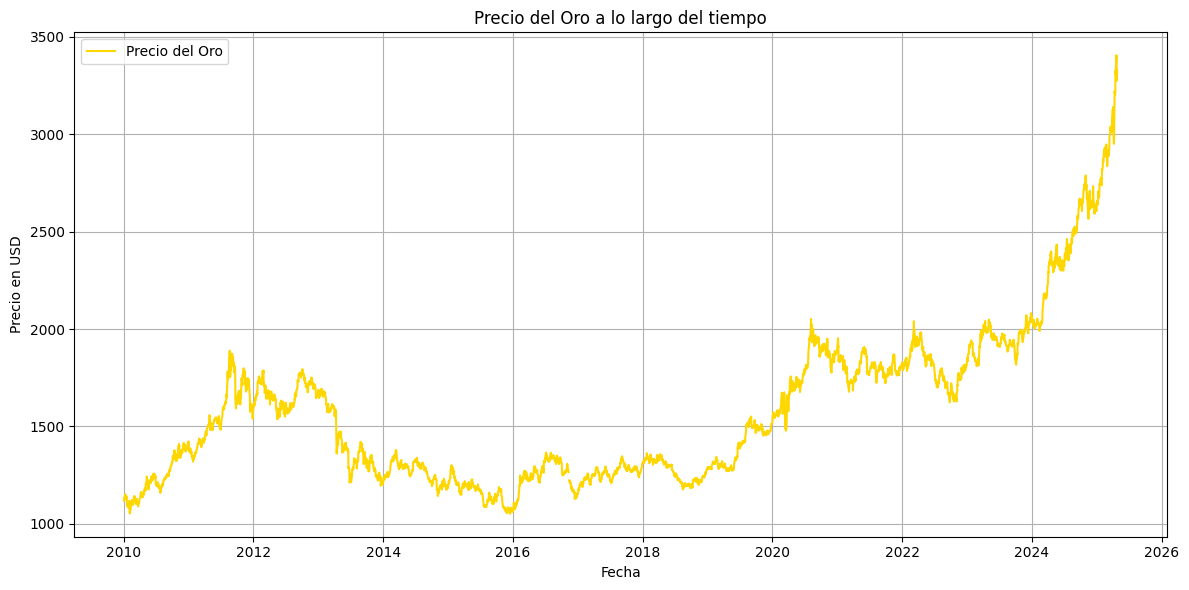

In [5]:
import matplotlib.pyplot as plt

# Suponiendo que tu DataFrame se llama df y tiene la columna "Oro"
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Oro"], label="Precio del Oro", color='gold')
plt.title("Precio del Oro a lo largo del tiempo")
plt.xlabel("Fecha")
plt.ylabel("Precio en USD")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 2.2 Feature Engineering
- **Ratio Oro/Dolar**: segun el USD (`Precio Oro / DXY`)
- **Inflacion implicita**: Variacion porcentual mensual del ETF TIP (proxy para CPI)
- **Tasa real aproximada**: Rendimiento bonos 10 años (^TNX - Inflacion implicita)

In [6]:
# Asegurarse de que el índice sea datetime
df.index = pd.to_datetime(df.index)

# 1. Re-samplear TIP a cierre mensual
tip_mensual = df['TIP'].resample('ME').last()

# 2. Calcular variación porcentual mensual
inflacion_mensual = tip_mensual.pct_change()

df['Infla_implicita'] = inflacion_mensual.reindex(df.index, method='ffill')
print("\nInflación implícita reindexada al DataFrame original:")
df[['TIP', 'Infla_implicita']].tail(15)



Inflación implícita reindexada al DataFrame original:


,TIP,Infla_implicita
Date,,
2025-04-04,110.599998,0.006797
2025-04-07,109.269997,0.006797
2025-04-08,109.000000,0.006797
2025-04-09,109.230003,0.006797
2025-04-10,107.930000,0.006797
2025-04-11,107.970001,0.006797
2025-04-14,108.489998,0.006797
2025-04-15,108.480003,0.006797
2025-04-16,108.779999,0.006797


In [7]:
df['Ratio_Oro_Dolar'] = df['Oro'] / df['DXY']

df['Tasa_real_aprox'] = df['Bonos_10y'] - df['Infla_implicita']

df.head()

,Oro,DXY,Bonos_10y,TIP,Infla_implicita,Ratio_Oro_Dolar,Tasa_real_aprox
Date,,,,,,,
2010-01-04,1117.699951,77.529999,3.841,71.393616,NaN,14.416355,NaN
2010-01-05,1118.099976,77.620003,3.755,71.626656,NaN,14.404792,NaN
2010-01-06,1135.900024,77.489998,3.808,71.441574,NaN,14.658666,NaN
2010-01-07,1133.099976,77.910004,3.822,71.551270,NaN,14.543703,NaN
2010-01-08,1138.199951,77.470001,3.808,71.702042,NaN,14.692138,NaN


> Los datos salen como `NaN` el primer mes unicamente porque no tiene nada contra lo que hacer el calculo de la variacion de la inflacion

Variables técnicas (complementarias):

- SMA de 200 días (identificar tendencias largas)
- Bandas de Bollinger (volatilidad histórica)

In [8]:
# ?

## 2.4 Ventana temporal

Estructurar los datos en secuencias de entrada-salida para entrenar la LSTM:

- Look-back (ventana histórica): 90 días de datos (precio oro, DXY, inflación implícita, ratio oro/dólar, volatilidad) como entrada.
- Forecast horizon (horizonte de predicción): 5 días futuros de precios de cierre del oro como salida.
- Normalización robusta: Usar RobustScaler para manejar outliers en crisis económicas.
- Reformateo: Transformar los datos en tensores 3D (muestras, pasos temporales, características) usando TimeseriesGenerator de Keras.

In [9]:
from sklearn.preprocessing import MinMaxScaler

df = df.dropna()
print("Shape después de limpiar:", df.shape)

scaler = MinMaxScaler()

data_scaled = scaler.fit_transform(df)


Shape después de limpiar: (3809, 7)


In [10]:
# Convertimos fechas a índices
dates = df.index
train_mask = (dates >= '2010') & (dates <= '2018')
val_mask = (dates >= '2019') & (dates <= '2020')
test_mask = (dates >= '2021')

train_end = np.where(train_mask)[0][-1]
val_start = np.where(val_mask)[0][0]
val_end = np.where(val_mask)[0][-1]
test_start = np.where(test_mask)[0][0]


In [11]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

def get_generator(data_scaled, start_idx, end_idx, look_back, horizon, batch_size=32, shuffle=False):
    data_slice = data_scaled[start_idx:end_idx]
    
    # Creamos los targets (5 días futuros del oro)
    targets = []
    for i in range(look_back, len(data_slice) - horizon + 1):
        future = data_slice[i:i + horizon, 0]
        targets.append(future)
    
    targets = np.array(targets)
    # Recortamos para que coincida con targets
    # data_trimmed = data_slice[:len(targets) + look_back]
    data_trimmed = data_slice[:len(targets)]
    
    generator = TimeseriesGenerator(
        data=data_trimmed,
        targets=targets,
        length=look_back,
        batch_size=batch_size,
        sampling_rate=1,
        stride=1,
        shuffle=shuffle
    )
    return generator


## 2.5 Division de datos

Dividir cronológicamente para preservar la integridad temporal:

- **Entrenamiento (2010-2018)**: Datos con crisis históricas relevantes.
- **Validación (2019-2020)**: Período COVID-19 para probar resiliencia ante shocks.
- **Test (2021-2024)**: Datos recientes con alta inflación y tensión geopolítica.

In [12]:
look_back = 90
horizon = 5
batch_size = 32

train_gen = get_generator(data_scaled, 0, train_end + 1, look_back, horizon, batch_size=batch_size, shuffle=True)
val_gen = get_generator(data_scaled, val_start, val_end + 1, look_back, horizon, batch_size=batch_size)
test_gen = get_generator(data_scaled, test_start, len(data_scaled), look_back, horizon, batch_size=batch_size)


In [13]:
# Ejemplo de forma
x_train, y_train = train_gen[0]
print(f"x_train: {x_train.shape}, y_train: {y_train.shape}")

x_val, y_val = val_gen[0]
print(f"x_val: {x_val.shape}, y_val: {y_val.shape}")

x_test, y_test = test_gen[0]
print(f"x_test: {x_test.shape}, y_test: {y_test.shape}")


x_train: (32, 90, 7), y_train: (32, 5)
x_val: (32, 90, 7), y_val: (32, 5)
x_test: (32, 90, 7), y_test: (32, 5)


In [14]:
print("Check X shape:", x_train.shape)
print("Check Y shape:", y_train.shape)
print("Check NaNs in X:", np.isnan(x_train).sum())
print("Check NaNs in Y:", np.isnan(y_train).sum())
print("Check infs in X:", np.isinf(x_train).sum())
print("Check infs in Y:", np.isinf(y_train).sum())
print("Y min/max:", y_train.min(), y_train.max())


Check X shape: (32, 90, 7)
Check Y shape: (32, 5)
Check NaNs in X: 0
Check NaNs in Y: 0
Check infs in X: 0
Check infs in Y: 0
Y min/max: 0.0022925628630521833 0.3143414846909912


# 3. Model planning

## 3.1 Definicion del problema

El proyecto se enmarca como un problema de regresión multivariante secuencial, donde múltiples características (precio del oro, índice DXY, inflación, tasas de interés o volumen) se usan para predecir una secuencia futura. La LSTM es ideal por su capacidad para recordar patrones a largo plazo y gestionar dependencias temporales complejas, como ciclos macroeconómicos, crisis geopolíticas, y correlación histórica oro-dólar.

## 3.2 Arquitectura de la red

- **Capa LSTM *(192 unidades)***: Captura relaciones complejas en secuencias largas (90 días), incluyendo patrones de demanda física (ej: compras centrales bancarias).
- **Dropout *(35%)***: Aleatoriza la desactivación de neuronas para contrarrestar sobreajuste en datos con eventos black-swan (ej: crisis 2008, COVID-19).
- **Capa LSTM *(96 unidades)***: Refina los patrones aprendidos, enfocándose en dependencias macroeconómicas a mediano plazo (ej: impacto de reuniones de la FED).
- **Capa Densa *(5 neuronas)***: Genera predicciones para los 5 días futuros, usando activación lineal para regresión.

## 3.3 Función de Pérdida y Optimizador

- **Función de pérdida**: Error cuadrático medio (***MSE***) con ponderación exponencial (da 2x más peso a errores en períodos de alta volatilidad).
- **Optimizador**: ***Adam*** con tasa de aprendizaje variable (lr=0.001 inicial, reduciendo a 0.0001 después de 50 épocas).
- **Métricas adicionales**:
    - ***MAE***: Error absoluto medio
    - ***Directional Accuracy***: Precisión direccional personalizada para oro (umbral de ±0.8% para considerar movimiento significativo)

### 3.3.1 Creacion de la tasa de aprendizaje variable


In [15]:
# Crear un callback para cambiar el learning rate después de 50 épocas
def scheduler(epoch, lr):
    if epoch == 50:
        return 0.0001
    else:
        return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

## 3.4 Estrategias Contra el Sobreajuste (OPCIONAL si lo ves necesario)

1. **Early Stopping**: Detener entrenamiento si pérdida en validación no mejora en 15 épocas
2. **Regularización L2 (λ=0.001)**: Aplicada solo a capas LSTM para evitar sobre-énfasis en features macroeconómicas.
3. **Aumentación de datos**: **<u>(OPCIONAL)</u>**
    - **Ruido gaussiano (σ=0.2)**: en secuencias de entrenamiento
    - **Time Warping**: Deformaciones temporales controladas (±5 días) para simular ciclos económicos acelerados/retrasados

# 4. Model building

## 4.1 Creacion y complicacion del modelo

In [16]:
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(90, 7)),
        tf.keras.layers.LSTM(192, return_sequences=True),
        tf.keras.layers.Dropout(0.35),

        tf.keras.layers.LSTM(96),
        tf.keras.layers.Dense(5) # Prediccion para 5 dias
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=[
            tf.keras.metrics.MeanAbsoluteError(),
            tf.keras.metrics.RootMeanSquaredError()
        ]
    )
    return model

## 4.2 Entrenamiento del modelo

In [17]:
if tf.config.list_physical_devices("GPU"):
    print("Usando GPU")
    with tf.device("GPU:0"):
        model = create_model()
        
        # TODO
        model.fit(
            x_train, y_train,
            epochs=1000,
            validation_data=(x_val, y_val),
            callbacks=[lr_callback],
            verbose=1
        )
else:
    print("Sin GPU")

Usando GPU


I0000 00:00:1745568552.603069    1545 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3586 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Epoch 1/1000


I0000 00:00:1745568563.400750    2182 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 0.0350 - mean_absolute_error: 0.1598 - root_mean_squared_error: 0.1870 - val_loss: 0.0041 - val_mean_absolute_error: 0.0585 - val_root_mean_squared_error: 0.0640 - learning_rate: 0.0010
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 0.0100 - mean_absolute_error: 0.0813 - root_mean_squared_error: 0.1002 - val_loss: 0.0043 - val_mean_absolute_error: 0.0552 - val_root_mean_squared_error: 0.0656 - learning_rate: 0.0010
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - loss: 0.0136 - mean_absolute_error: 0.0971 - root_mean_squared_error: 0.1166 - val_loss: 0.0024 - val_mean_absolute_error: 0.0425 - val_root_mean_squared_error: 0.0491 - learning_rate: 0.0010
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - loss: 0.0113 - mean_absolute_error: 0.0884 - root_mean_squared_error: 0.1063 - val_loss: 2.7020e-04 - val_mean_absolute_error: 0.0130 - val_root_mean_squared_error: 0.0164 - learning_rate: 0.0010
Epoch 5/1000
1/1 ━━━━━━━━━━━

In [18]:
results = model.evaluate(x_test, y_test, verbose=0)

metric_names = ['Loss', 'MAE', 'RMSE']

for name, result in zip(metric_names, results):
    if name=='Loss':
        print(f"{name}: {result}")
    else:
        print(f"{name}: {result * 100:.2f}")

Loss: 0.002362817293033004
MAE: 4.78
RMSE: 4.86


In [19]:
y_pred = model.predict(x_test)

print(y_pred[0])
print(y_pred.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
[0.2560058  0.24767448 0.24431343 0.23828539 0.24174716]
(32, 5)


# 5. Presentacion de resultados

In [20]:
# Reinsertamos los valores predichos en la columna del oro (posición 0), el resto va con ceros
def desescalar_columna_oro(y_scaled, scaler, feature_index=0, total_features=7):
    y_extended = np.zeros((y_scaled.shape[0], total_features))
    y_extended[:, feature_index] = y_scaled[:, 0]  # insertamos el oro en su lugar original
    y_inverted = scaler.inverse_transform(y_extended)
    return y_inverted[:, feature_index]  # solo devolvemos la columna del oro

# Uso
y_test_inv = desescalar_columna_oro(y_test, scaler)
y_pred_inv = desescalar_columna_oro(y_pred, scaler)


In [21]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

def evaluar_modelo(y_true, y_pred, nombre=""):
    rmse = root_mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{nombre} → RMSE: {rmse}, MAE: {mae}")

evaluar_modelo(y_test, y_pred, "Test")


Test → RMSE: 0.04814958834064367, MAE: 0.047776582795036396


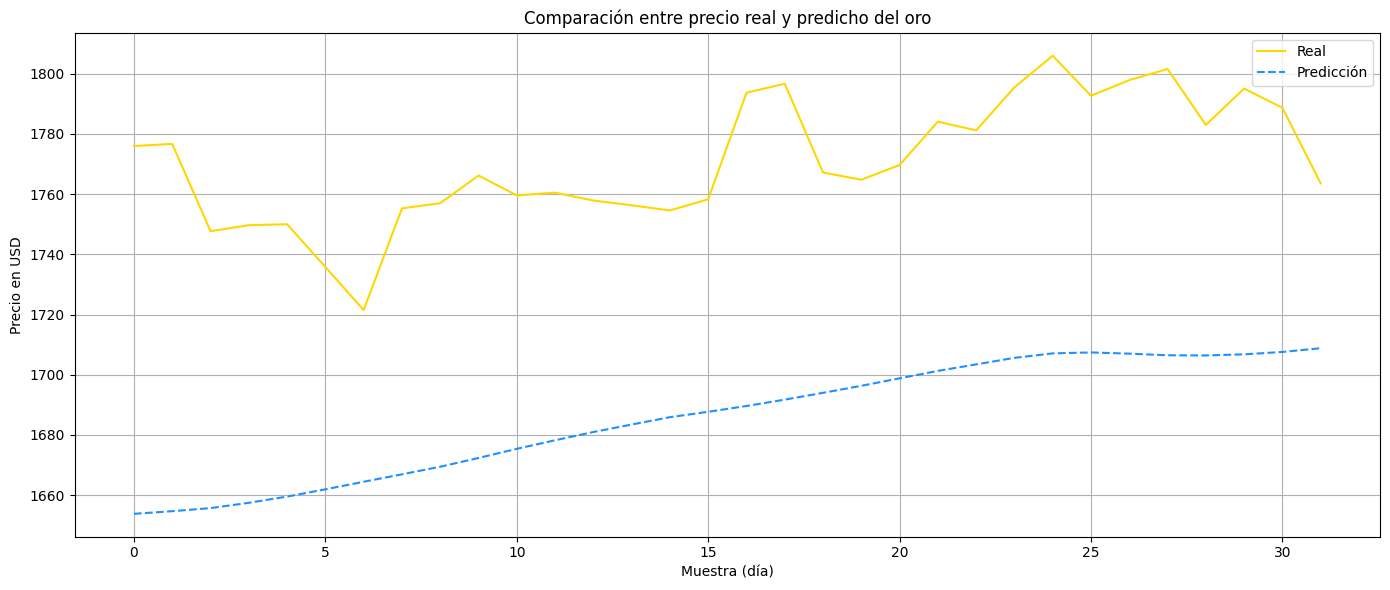

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(y_test_inv, label="Real", color='gold')
plt.plot(y_pred_inv, label="Predicción", color='dodgerblue', linestyle='--')
plt.title("Comparación entre precio real y predicho del oro")
plt.xlabel("Muestra (día)")
plt.ylabel("Precio en USD")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 6. Deployment

### Exportacion en formato `.h5`

In [ ]:
model.save("modelo_images.h5")

### Exportacion en formato `.keras` 

In [ ]:
model.save("modelo_images.keras")